In [1]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import joblib
from sklearn.pipeline import  Pipeline
import warnings
warnings.filterwarnings('ignore')
from utils import collect_error_metrics, get_model_acc_via_r2
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import set_config
import xgboost as xgb
set_config(display='diagram')

color_pal = sns.color_palette()

# Get our dataset and drop unecessary columns
df = pd.read_parquet('Data/Tifton_SPI_FE.parquet')
df = df.drop(['date', 'hour'], axis=1)


# Label encode particular columns of strings for easier processing
le = LabelEncoder()
df['season'] = le.fit_transform(df['season'])
df['weekday'] = le.fit_transform(df['weekday'])
df['day'] = le.fit_transform(df['day'])


## Add lag features

In [2]:
def add_lags(df):
    target_map = df['SPI'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df


In [3]:
df = add_lags(df)

## Begin preparing for modeling

In [4]:
# Create Train Test Split
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

In [5]:



# Define Features
FEATURES = ['prcp_accum', 'air_temp_avg', 'smp_2', 'smp_4', 'smp_8', 'smp_20',
            'smp_40', 'soil_temp_2', 'soil_temp_4', 'soil_temp_8', 'soil_temp_20',
            'soil_temp_40', 'wind_dir_avg', 'wind_speed_avg', 'PRCP', 'year',
            'month', 'day', 'dayofweek', 'weekday', 'quarter', 'dayofyear',
            'dayofmonth', 'weekofyear', 'date_offset', 'season', 'soil_temp_avg',
            'smp_avg', 'lag1','lag2','lag3']

# Declare Target feature
TARGET = 'SPI'




In [6]:
# Collect pickle files from earlier
preprocessor = joblib.load('Models/preprocessor.pkl')
XGD_model = joblib.load('Models/Tuned_Large_XGBoost.pkl')

In [7]:
XGD_model_pipeline = Pipeline(steps=[('preprocessing', preprocessor), ('reg', XGD_model)])
XGD_model_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['prcp_accum', 'air_temp_avg',
                                                   'smp_2', 'smp_4', 'smp_8',
                                                   'smp_20', 'smp_40',
                                                   'soil_temp_2', 'soil_temp_4',
                                                   'soil_temp_8',
                                                   'soil_temp_20',
                                                   'soil_temp_40',
                                                   'wind_dir_avg',
                                                   'wind...
                              interaction_constraints='', learning_rate=0.2,
                              max_delta_step=0, max_depth=14,
                              min_child_weight=4.0, missing=nan,
                              monotone_constraints='()', n_estimators=80,
                              n_jobs=12, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=165.0,
                              reg_lambda=0.2417664261493942, scale_pos_weight=1,
                              seed=0, subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

## Train models using CV and Stratified K-Folds

In [8]:
df

,prcp_accum,air_temp_avg,smp_2,smp_4,smp_8,smp_20,smp_40,soil_temp_2,soil_temp_4,soil_temp_8,...,dayofmonth,weekofyear,date_offset,week,season,soil_temp_avg,smp_avg,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,,,,,,,
2008-11-01,4.90,12.0,8.8,8.5,11.0,12.3,24.0,13.8,14.3,15.7,...,1,44,781,44,0,16.16,12.92,NaN,NaN,NaN
2008-11-02,4.90,12.8,8.7,8.3,10.4,12.2,24.1,15.3,15.5,16.1,...,2,44,782,44,0,16.72,12.74,NaN,NaN,NaN
2008-11-03,4.90,15.2,8.6,8.2,10.6,12.2,23.9,15.3,15.7,16.5,...,3,45,783,45,0,16.84,12.70,NaN,NaN,NaN
2008-11-04,4.90,16.9,8.5,8.1,10.0,11.7,23.9,17.1,17.4,17.7,...,4,45,784,45,0,17.90,12.44,NaN,NaN,NaN
2008-11-05,4.90,16.6,8.5,8.0,10.0,11.9,23.7,16.7,17.0,17.5,...,5,45,785,45,0,17.74,12.42,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-27,3.18,13.0,7.5,8.1,10.0,9.2,24.5,13.5,13.2,16.1,...,27,48,807,48,0,14.60,11.86,-2.190902,-2.190902,-2.190902
2017-11-28,3.18,10.5,7.1,7.9,10.5,8.8,24.7,13.2,12.9,15.6,...,28,48,808,48,0,14.26,11.80,-1.978879,-2.190902,-2.190902
2017-11-29,3.18,15.6,6.7,7.9,10.0,9.2,24.6,15.2,14.7,16.6,...,29,48,809,48,0,15.22,11.68,-2.190902,-2.190902,-2.190902


[0]	validation_0-rmse:2.69090	validation_1-rmse:2.43433
[79]	validation_0-rmse:2.69090	validation_1-rmse:2.43433
[0]	validation_0-rmse:2.07476	validation_1-rmse:2.03091
[79]	validation_0-rmse:0.68503	validation_1-rmse:0.65087
[0]	validation_0-rmse:1.99973	validation_1-rmse:2.07851
[79]	validation_0-rmse:0.41853	validation_1-rmse:0.45130
[0]	validation_0-rmse:2.00219	validation_1-rmse:2.01609
[79]	validation_0-rmse:0.31179	validation_1-rmse:0.30492
[0]	validation_0-rmse:1.99496	validation_1-rmse:1.93796
[79]	validation_0-rmse:0.26704	validation_1-rmse:0.40218
[0]	validation_0-rmse:1.98087	validation_1-rmse:1.91105
[79]	validation_0-rmse:0.25444	validation_1-rmse:0.26273
[0]	validation_0-rmse:1.96780	validation_1-rmse:1.97095
[79]	validation_0-rmse:0.23762	validation_1-rmse:0.26601
[0]	validation_0-rmse:1.96613	validation_1-rmse:1.94349
[79]	validation_0-rmse:0.22713	validation_1-rmse:0.25189
[0]	validation_0-rmse:1.96135	validation_1-rmse:2.00944
[79]	validation_0-rmse:0.22659	validatio

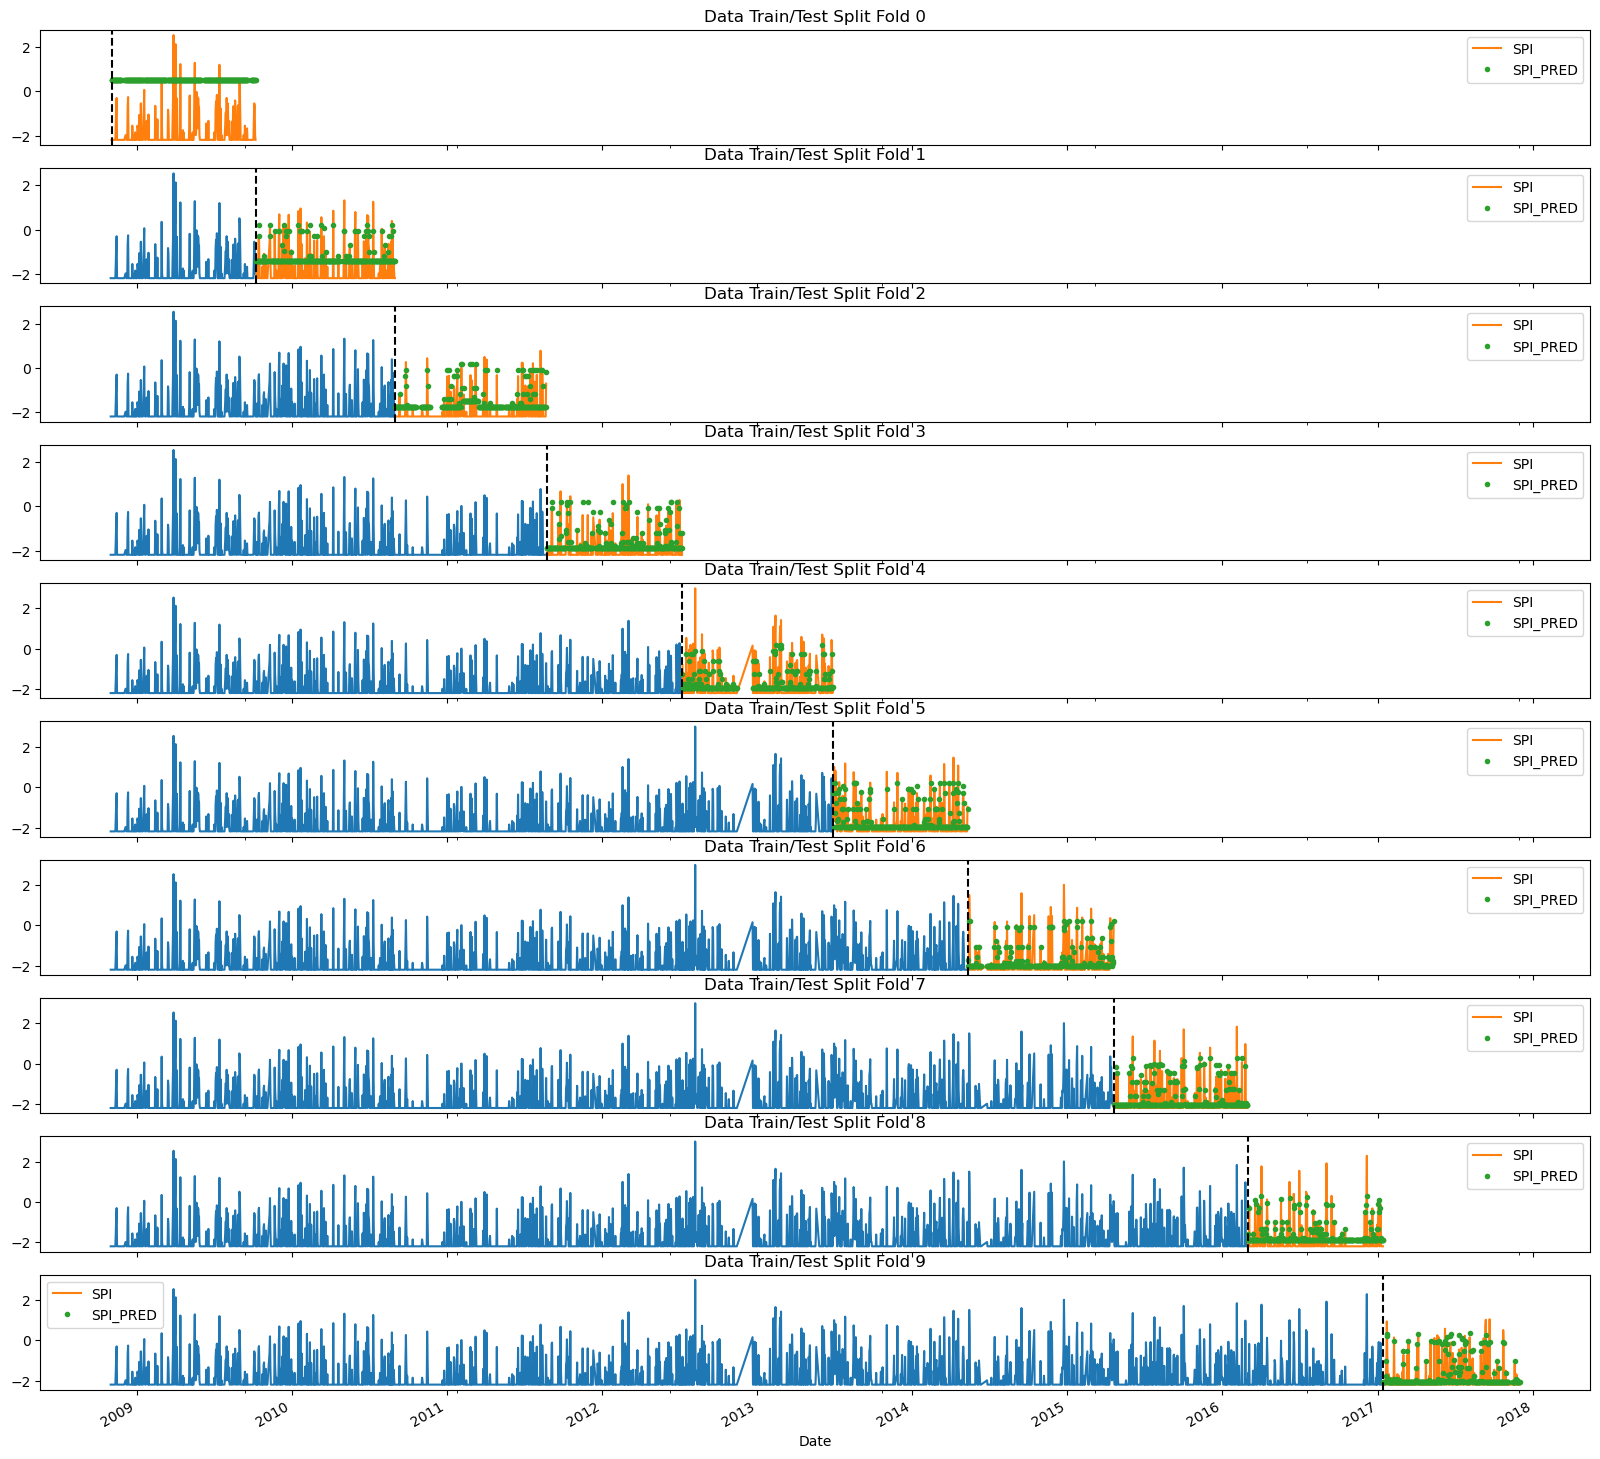

In [9]:
tss = TimeSeriesSplit(n_splits=10, test_size=313, gap=1)
df = df.sort_index()



fig, axs = plt.subplots(10, 1, figsize=(20, 20), sharex=True)

fold = 0
preds = []
scores = []
accs = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    n_test = test.copy()
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]



    reg = XGD_model_pipeline

    X_train_tf = reg[:-1].fit_transform(X_train)
    X_test_tf = reg[:-1].fit_transform(X_test)

    reg[-1].fit(X_train_tf, y_train,
            eval_set=[(X_train_tf, y_train), (X_test_tf, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    n_test['SPI_PRED'] = y_pred

    train['SPI'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    n_test[['SPI','SPI_PRED']].plot(ax=axs[fold],
                         label='Test Set',style=['-','.'])
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1


    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    accs.append(get_model_acc_via_r2(y_test, y_pred))

In [10]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')
print(f'Fold Accuracy Percentages: {accs}')

Score across folds 0.5585
Fold scores:[2.434333354812897, 0.6508712231453136, 0.4513016432911847, 0.30491805216732454, 0.4021755292921482, 0.26273421736721037, 0.26600973663519656, 0.2518893679412107, 0.3474580783995942, 0.2133883785890074]
Fold Accuracy Percentages: [-900.0, 31.0, 46.0, 78.0, 79.0, 89.0, 88.0, 89.0, 79.0, 91.0]


## Future Prediction

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)



In [12]:
X_all = df[FEATURES]
y_all = df[TARGET]


reg = XGD_model_pipeline

X_all_tf = reg[:-1].fit_transform(X_all)
reg[-1].fit(X_all_tf, y_all, eval_set=[(X_all_tf, y_all)], verbose=100)


[0]	validation_0-rmse:1.96402
[79]	validation_0-rmse:0.21386


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.618705915332379,
             enable_categorical=False, gamma=6.927325498908001, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=14,
             min_child_weight=4.0, missing=nan, monotone_constraints='()',
             n_estimators=80, n_jobs=12, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=165.0, reg_lambda=0.2417664261493942,
             scale_pos_weight=1, seed=0, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [13]:
df.index.max()

Timestamp('2017-12-01 00:00:00')

In [14]:
df

,prcp_accum,air_temp_avg,smp_2,smp_4,smp_8,smp_20,smp_40,soil_temp_2,soil_temp_4,soil_temp_8,...,weekofyear,date_offset,week,season,soil_temp_avg,smp_avg,lag1,lag2,lag3,hour
Date,,,,,,,,,,,,,,,,,,,,,
2008-11-01,4.90,12.0,8.8,8.5,11.0,12.3,24.0,13.8,14.3,15.7,...,44,781,44,0,16.16,12.92,NaN,NaN,NaN,0
2008-11-02,4.90,12.8,8.7,8.3,10.4,12.2,24.1,15.3,15.5,16.1,...,44,782,44,0,16.72,12.74,NaN,NaN,NaN,0
2008-11-03,4.90,15.2,8.6,8.2,10.6,12.2,23.9,15.3,15.7,16.5,...,45,783,45,0,16.84,12.70,NaN,NaN,NaN,0
2008-11-04,4.90,16.9,8.5,8.1,10.0,11.7,23.9,17.1,17.4,17.7,...,45,784,45,0,17.90,12.44,NaN,NaN,NaN,0
2008-11-05,4.90,16.6,8.5,8.0,10.0,11.9,23.7,16.7,17.0,17.5,...,45,785,45,0,17.74,12.42,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-27,3.18,13.0,7.5,8.1,10.0,9.2,24.5,13.5,13.2,16.1,...,48,807,48,0,14.60,11.86,-2.190902,-2.190902,-2.190902,0
2017-11-28,3.18,10.5,7.1,7.9,10.5,8.8,24.7,13.2,12.9,15.6,...,48,808,48,0,14.26,11.80,-1.978879,-2.190902,-2.190902,0
2017-11-29,3.18,15.6,6.7,7.9,10.0,9.2,24.6,15.2,14.7,16.6,...,48,809,48,0,15.22,11.68,-2.190902,-2.190902,-2.190902,0


In [15]:
# Create future dataframe
future = pd.date_range('2017-12-01','2018-12-01', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [16]:
future_w_features = df_and_future.query('isFuture').copy()

In [17]:
future_w_features

,prcp_accum,air_temp_avg,smp_2,smp_4,smp_8,smp_20,smp_40,soil_temp_2,soil_temp_4,soil_temp_8,...,date_offset,week,season,soil_temp_avg,smp_avg,lag1,lag2,lag3,hour,isFuture
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-2.190902,-2.190902,-2.190902,0,True
2017-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-2.190902,-2.190902,-2.190902,0,True
2017-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-2.190902,-2.190902,-2.190902,0,True
2017-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.199838,-2.190902,-2.190902,0,True
2017-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.290820,-2.190902,-2.190902,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-2.190902,-1.978879,-2.190902,0,True
2018-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-2.190902,-2.190902,-2.190902,0,True
2018-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-2.190902,-0.621446,0.799350,0,True
2018-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.190902,-2.190902,0,True


In [18]:
future_w_features['pred'] = reg.predict(reg[:-1].fit_transform(future_w_features[FEATURES]))

ValueError: Found array with 0 feature(s) (shape=(366, 0)) while a minimum of 1 is required by StandardScaler.

In [ ]:
future_w_features

In [ ]:


future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()



In [ ]:
models_list = [XGD_model_pipeline, GRB_model_pipeline]
pred_series = []
for i in models_list:
    # Make X_train, y_train, X_test, y_test
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    ################################
    i.fit(X_train, y_train)
    y_pred = i.predict(X_test)
    name = f"{i.named_steps['reg'].__class__.__name__}"
    test[f'SPI_PRED_{name}'] = y_pred
    #####################################
    RMSE, MAE, MAPE = collect_error_metrics(test, 'SPI', f"SPI_PRED_{name}")
    score = r2_score(y_test, y_pred)
    print('Stats for', name)
    print(f"Real Mean Squared Error: {RMSE}\nMean Absolute Error: {MAE}\nMean Absolute Percent Error: {round(MAPE,2)*100}")
    print("The accuracy of our model is {}%".format(round(score, 2) *100))


In [ ]:
spi_all = pd.concat([train, test], sort=False)
_ = spi_all[['SPI', 'SPI_PRED_XGBRegressor','SPI_PRED_GradientBoostingRegressor']].plot(figsize=(15, 5))

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = spi_all[['SPI_PRED_XGBRegressor','SPI_PRED_GradientBoostingRegressor','SPI']].plot(ax=ax,
                                              style=['.','.','-'])
ax.set_ylim(-3, 3)
ax.set_xbound(lower='01-01-2016', upper='02-01-2016')
plot = plt.suptitle('Month of predictions, Jan, 2016')

In [ ]:
SPI_test = test.copy()

In [ ]:
SPI_test['error_xgb'] = SPI_test['SPI'] - SPI_test['SPI_PRED_XGBRegressor']
SPI_test['abs_error_xgb'] = SPI_test['error_xgb'].apply(np.abs)
SPI_test['error_gbr'] = SPI_test['SPI'] - SPI_test['SPI_PRED_GradientBoostingRegressor']
SPI_test['abs_error_gbr'] = SPI_test['error_gbr'].apply(np.abs)
error_by_month = SPI_test.groupby(['year', 'month']).mean()[['SPI','SPI_PRED_GradientBoostingRegressor','SPI_PRED_XGBRegressor','error_xgb','abs_error_xgb', 'error_gbr','abs_error_gbr']]

In [ ]:
# Worst Predicted year
error_by_month.sort_values(['error_gbr','error_xgb'], ascending=True).head(10)